<a href="https://colab.research.google.com/github/alfa7g7/Analisis-Cuantitativo-1er-semestre/blob/main/Examen_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS APLICADAS MAESTRÍA EN CIENCIA DE DATOS TIC 60153 – Análisis Cuantitativo Examen 2 (50 %): Modelos de Regularización

### Ejercicio 1. 1)	Considere el conjunto de datos “Boston Housing Data” presentados en Harrison and Rubinfeld (1978). Defina como variable respuesta a la columna MEDV. Realice una partición 80-20, donde el primer 80 % de los datos son datos de entrenamiento y el restante 20 % son datos para prueba.


- Genere los modelos de regresión por regularización **Ridge, LASSO y Elastic-Net** para los datos de entrenamiento. Encuentre los valores óptimos de $α$ y $λ$ junto a su respectiva gráfica de evolución de los coeficientes de regresión. Compare los modelos en términos de la selección de variables, interprete los coeficientes y escriba la ecuación ajustada de regresión para cada caso. Finalmente, realice una predicción con las observaciones de prueba y determine cual de los tres modelos es el mejor en capacidad predictiva **(RMSE)**.
- Sea $Z ∈ \mathbb{R}^{n \times p}$ una muestra de datos multivariantes. La distancia de Mahalanobis (MD), presentado por Mahalanobis (1936) y conocida como la distancia estadística, se define de la siguiente forma:
$$MD(zi) = \sqrt{(zi − \hatµ)'\hat{∑}^{-1}(zi - \hat{µ})},\  para\ i=1, . . . , n.$$
Donde $xi ∈ \mathbb{R}^{p\times1}$ denota una observación (fila), pero transpuesta, de la muestra, $\hat{µ} ∈ \mathbb{R}^{p\times1}$ el vector de medias (vector con los promedios de cada columna o variable) y $\hat{Σ}^{−1} ∈ \mathbb{R}^{p\times p}$ la inversa de la matriz de covarianza de los datos. MD puede interpretarse como la distancia
que tiene cada individuo de la muestra al individuo ideal o equilibrio (representado por $\hat{µ}$), considerando la estructura de dependencia de las variables.

  Esta distancia tiene múltiples usos, como por ejemplo la detección de observaciones atípicas. Se dice que una observación $zi$ es atípica sí $MD(zi)> \chi^{2}_{(q,p)},$ donde q denota un percentil, usualmente $q ∈ [0.95, 0.99]$, de la distribución Chi-squared de parámetro $p$.
  
  De acuerdo a la información anterior: Detecte las observaciones atípicas multivariantes de la muestra, usando $q = 0.90, 0.95, 0.975, 0.99$ y en un gráfico muestre las distancias calculadas para cada individuo y los puntos de corte $(\chi^{2}_{(q,p)})$ ¿Qué puede concluir acerca de los individuos atípicos para cada punto de corte? ¿Quienes son? ¿El gráfico de distancias muestra alguna observación NO atípica que para usted si lo fue? ¿Qué puede concluir acerca del comportamiento de q en el valor del punto de corte? Justifique detalladamente.

- Realice dos modelos de regresión Robusto–Regularizado, combinando la técnica de detección de atípicos multivariantes más la regularización Elastic-Net. Encuentre los valores óptimos de $α^{*}$ y $λ^{*}$, interprete los coeficientes de regresión, escriba la respectiva ecuación de regresión resultante y valide los supuestos del modelo $(ε_i \ iid∼   N(0, σ^{2}))$. Finalmente, realice una predicción con las observaciones de prueba y determine el **RMSE** de estos dos modelos. Compare los resultados con los modelos estimados en el ítem 1.

  NOTA: La aplicación de la técnica de detección de atípicos debe realizarla de la siguiente manera:
  
  - Modelo 1: Estandarizar las variables y calcular MD usando el vector de medianas en vez del vector de medias y la matriz de correlación de Spearman en vez de la matriz de covarianzas usual. Luego, eliminar los atípicos y con la muestra limpia estimar el modelo regularizado.

  - Modelo 2: Estandarizar las variables y calcular MD usando el vector de medianas en vez del vector de medias y la matriz de correlación de Spearman en vez de la matriz de covarianzas usual. Luego, determinar como observaciones NO atípicas los primeros r n+p+1 l individuos con las distancias más pequeñas. Finalmente, con la muestra limpia estimar el modelo regularizado.
  
  Ejemplo: Si $n = 1000$ y $p = 100$ entonces r n+p+1 l = r 1000+100+1 l = r550.5l = 551. 2	2 Es decir, debe identificar como NO atípicos los 551 individuos de la muestra con las distancias de Mahalanobis más pequeñas.


#### Librerias a importar

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from itertools import combinations

#### Importación del conjunto de datos Boston

**Nota:**  
El dataset de boston ha sido removido de sklearn.datasets, su importación se ha cancelado por un tema de racismo. Usamos su versión original y agregamos el enlace de la misma. Al final también elimnamos la variable que hace alusión a este tema
[Fuente del conjunto de datos](https://lib.stat.cmu.edu/datasets/boston)

In [3]:
# Carga del conjunto de datos reemplazando la forma deshabilitada por ser racista desde la fuente original
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None,
  names=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Acomodando un dataframe df con todo el conjunto de datos y sus nombres de columnas
df = pd.DataFrame(data)
df = df.assign(target=target)
df = df.drop(columns=[11, 12, 13])
df.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

#NO al racismo jamás, quitamos la columna que hace referencia al estudio racista y sin ella trabajaremos.
df = df.drop(columns='B')

#### EDA

In [4]:
# Forma de dataframe df
df.shape

(506, 13)

In [5]:
# Columnas o variables del dataframe df
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT', 'MEDV'],
      dtype='object')

In [7]:
# primeros valores del dataframe df (5 valores)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [8]:
# Últimos valores del dataframe df (5 valores)
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,7.88,11.9


In [9]:
# Número de filas por columna o variable
df.count()

CRIM       506
ZN         506
INDUS      506
CHAS       506
NOX        506
RM         506
AGE        506
DIS        506
RAD        506
TAX        506
PTRATIO    506
LSTAT      506
MEDV       506
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Visualmente podemos inferir que no tenemos ni un valor nulo o ningún valor vacío. son 506 valores por cada variable, todo caracterizados de tipo de datos flotante.

In [11]:
# verificacion de datos NaN en el dataframe
print(f'¿Hay algún valor NaN (Not a number)? {df.isna().values.any()}')

¿Hay algún valor NaN (Not a number)? False


In [14]:
# Descripción estadística del dataframe df
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


In [16]:
# Determinamos el valor de correlaciones entre las variables

# correlacion de pearson
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536


In [17]:
# correlacion de kendall
df.corr(method = "kendall")

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.462057,0.521014,0.033948,0.603361,-0.211718,0.497297,-0.539878,0.563969,0.544956,0.312768,0.454837,-0.403964
ZN,-0.462057,1.000000,-0.535468,-0.039419,-0.511464,0.278134,-0.429389,0.478524,-0.234663,-0.289911,-0.361607,-0.386818,0.339989
INDUS,0.521014,-0.535468,1.000000,0.075889,0.612030,-0.291318,0.489070,-0.565137,0.353967,0.483228,0.336612,0.465980,-0.418430
CHAS,0.033948,-0.039419,0.075889,1.000000,0.056387,0.048080,0.055616,-0.065619,0.021739,-0.037655,-0.115694,-0.041344,0.115202
NOX,0.603361,-0.511464,0.612030,0.056387,1.000000,-0.215633,0.589608,-0.683930,0.434828,0.453258,0.278678,0.452005,-0.394995
RM,-0.211718,0.278134,-0.291318,0.048080,-0.215633,1.000000,-0.187611,0.179801,-0.076569,-0.190532,-0.223194,-0.468231,0.482829
AGE,0.497297,-0.429389,0.489070,0.055616,0.589608,-0.187611,1.000000,-0.609836,0.306201,0.360311,0.251857,0.485359,-0.387758
DIS,-0.539878,0.478524,-0.565137,-0.065619,-0.683930,0.179801,-0.609836,1.000000,-0.361892,-0.381988,-0.223486,-0.409347,0.313115
RAD,0.563969,-0.234663,0.353967,0.021739,0.434828,-0.076569,0.306201,-0.361892,1.000000,0.558107,0.251913,0.287943,-0.248115
TAX,0.544956,-0.289911,0.483228,-0.037655,0.453258,-0.190532,0.360311,-0.381988,0.558107,1.000000,0.287769,0.384191,-0.414650


In [18]:
# correlacion de Spearman
df.corr(method = "spearman")

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,0.634760,-0.558891
ZN,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,-0.490074,0.438179
INDUS,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,0.638747,-0.578255
CHAS,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.050575,0.140612
NOX,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,0.636828,-0.562609
RM,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,-0.640832,0.633576
AGE,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,0.657071,-0.547562
DIS,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,-0.564262,0.445857
RAD,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,0.394322,-0.346776
TAX,0.729045,-0.371394,0.664361,-0.044486,0.649527,-0.271898,0.526366,-0.574336,0.704876,1.000000,0.453345,0.534423,-0.562411


In [23]:

# Determinamos el valor de correlacion de todos las variables para la variable MEDV
# desde el más significativo al menos
correlacion = df.corr()
correlacion['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

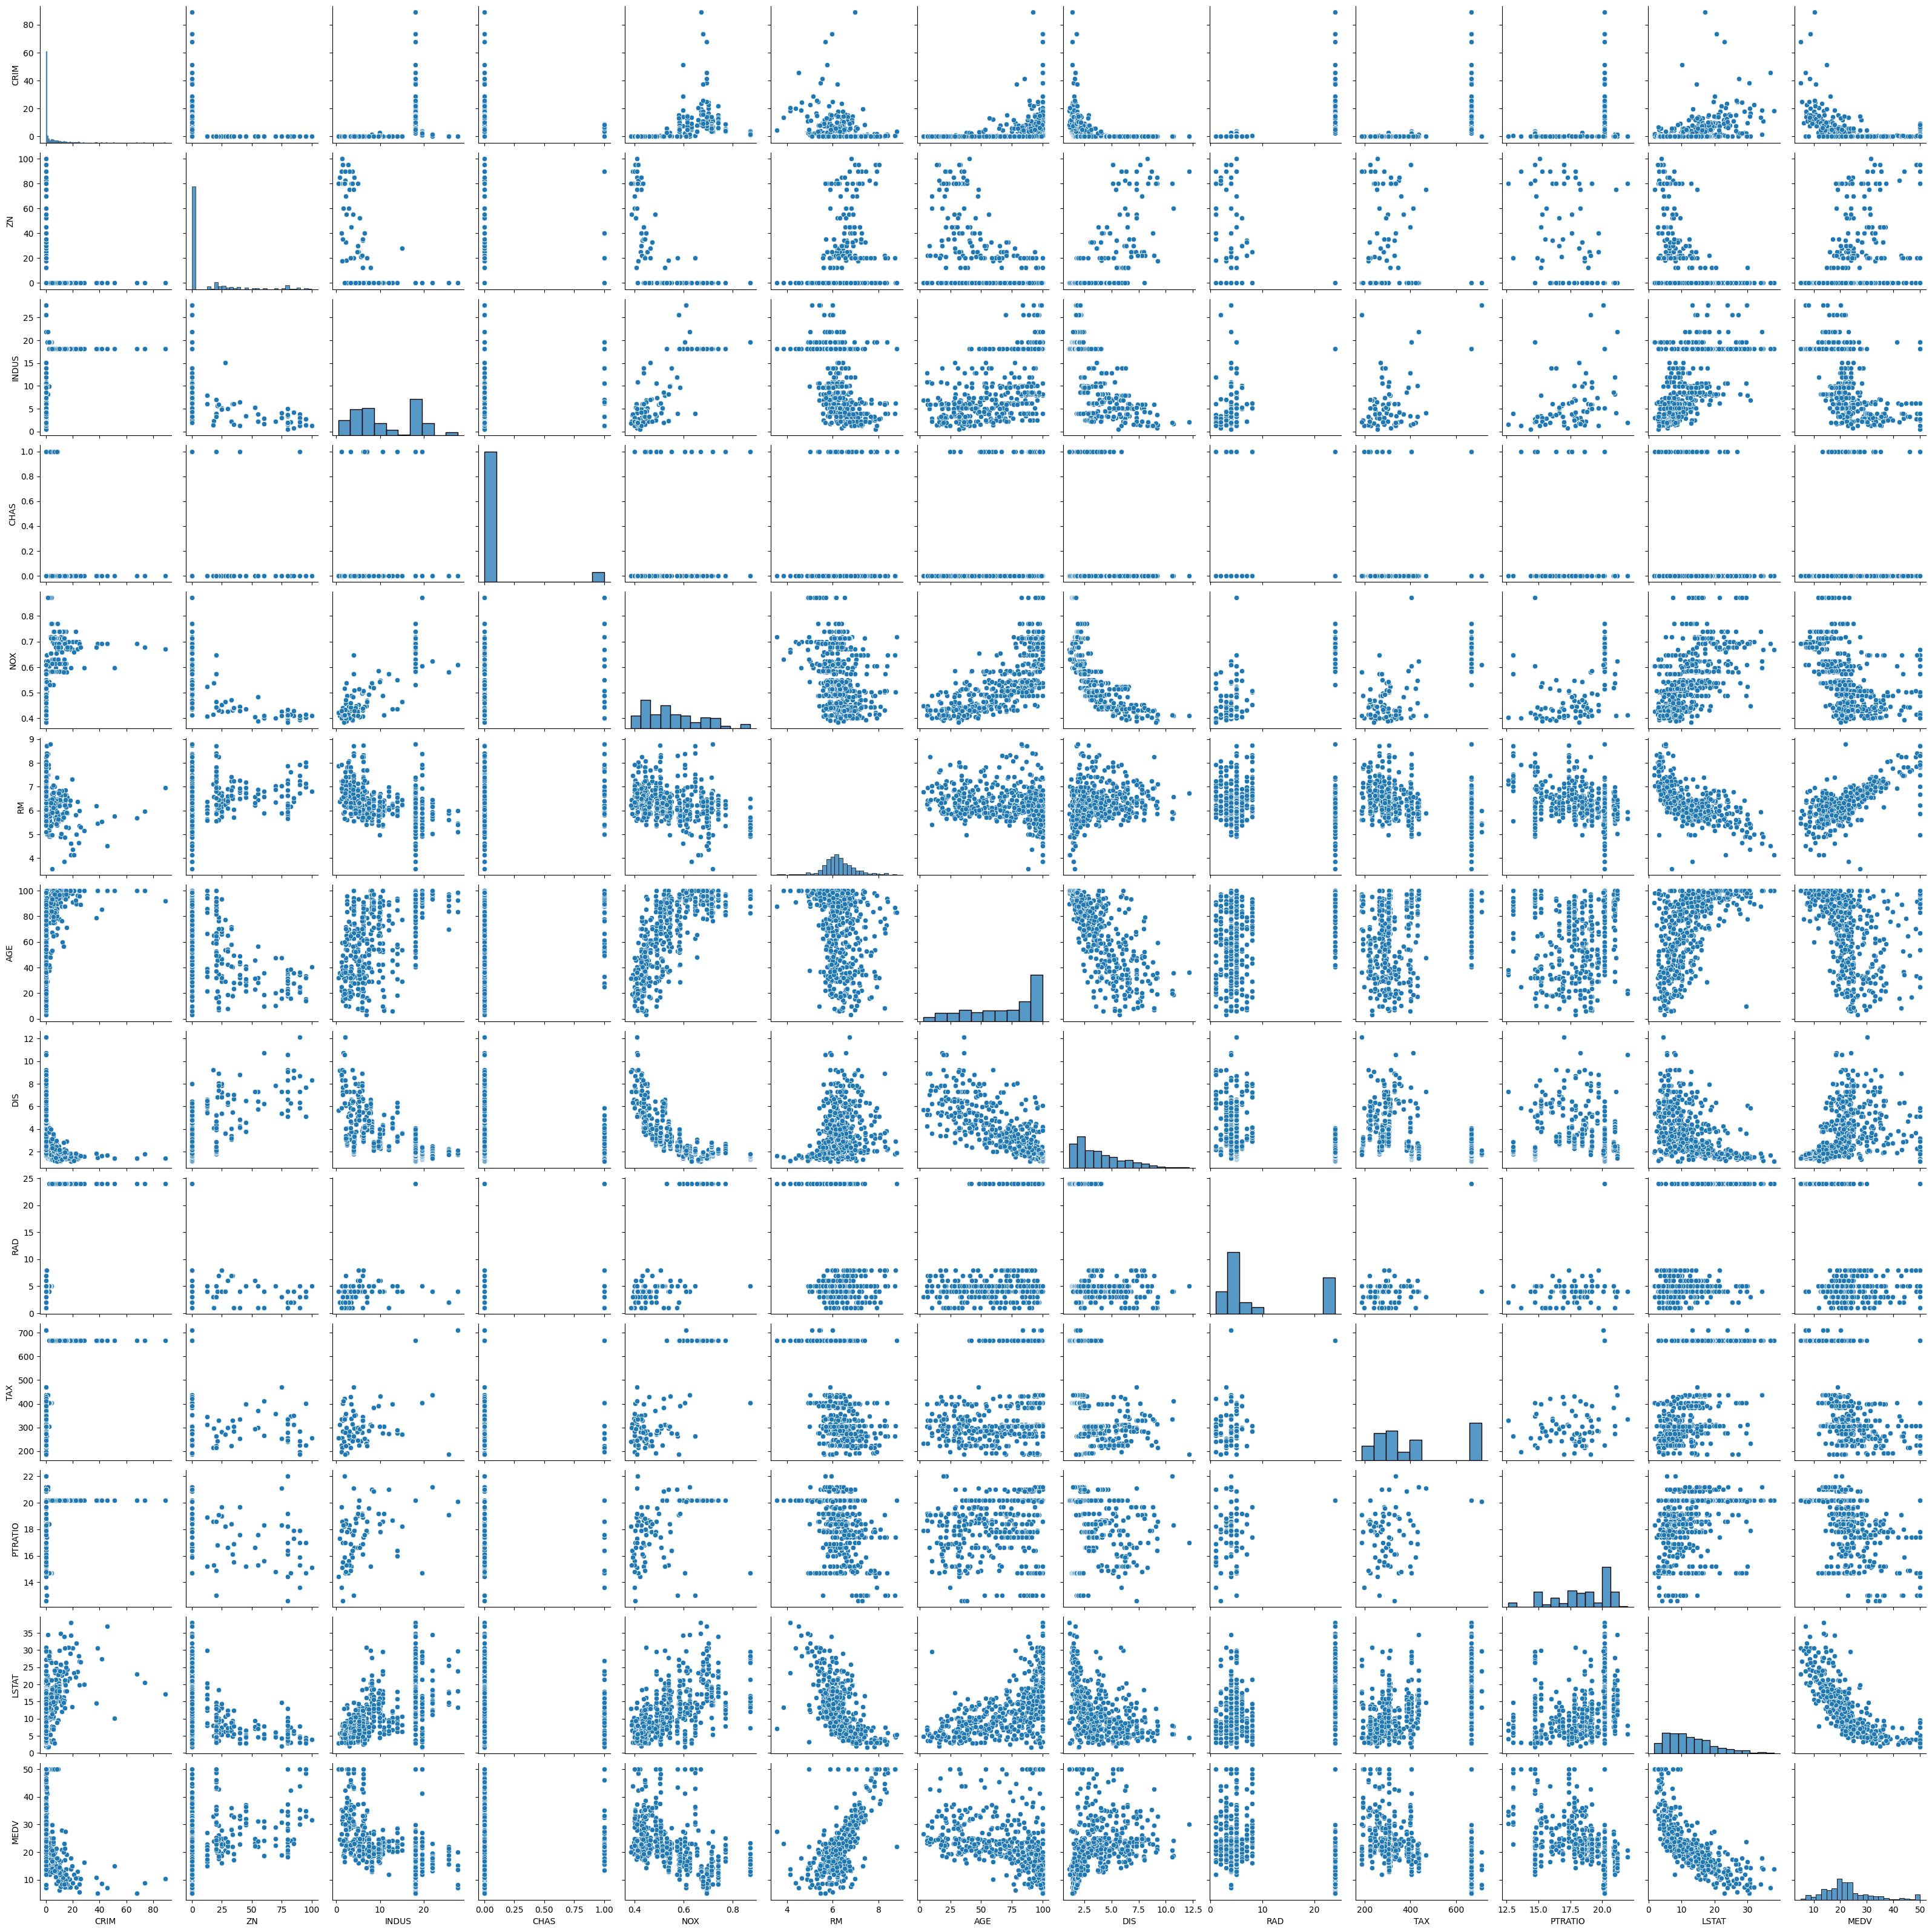

In [15]:
# Analizamos el histograma (Observados en la diagonal) y dispersión
# (Observados en la anti-diagonal) para cada una de las variables del dataframe 'df'
sns.pairplot(df)

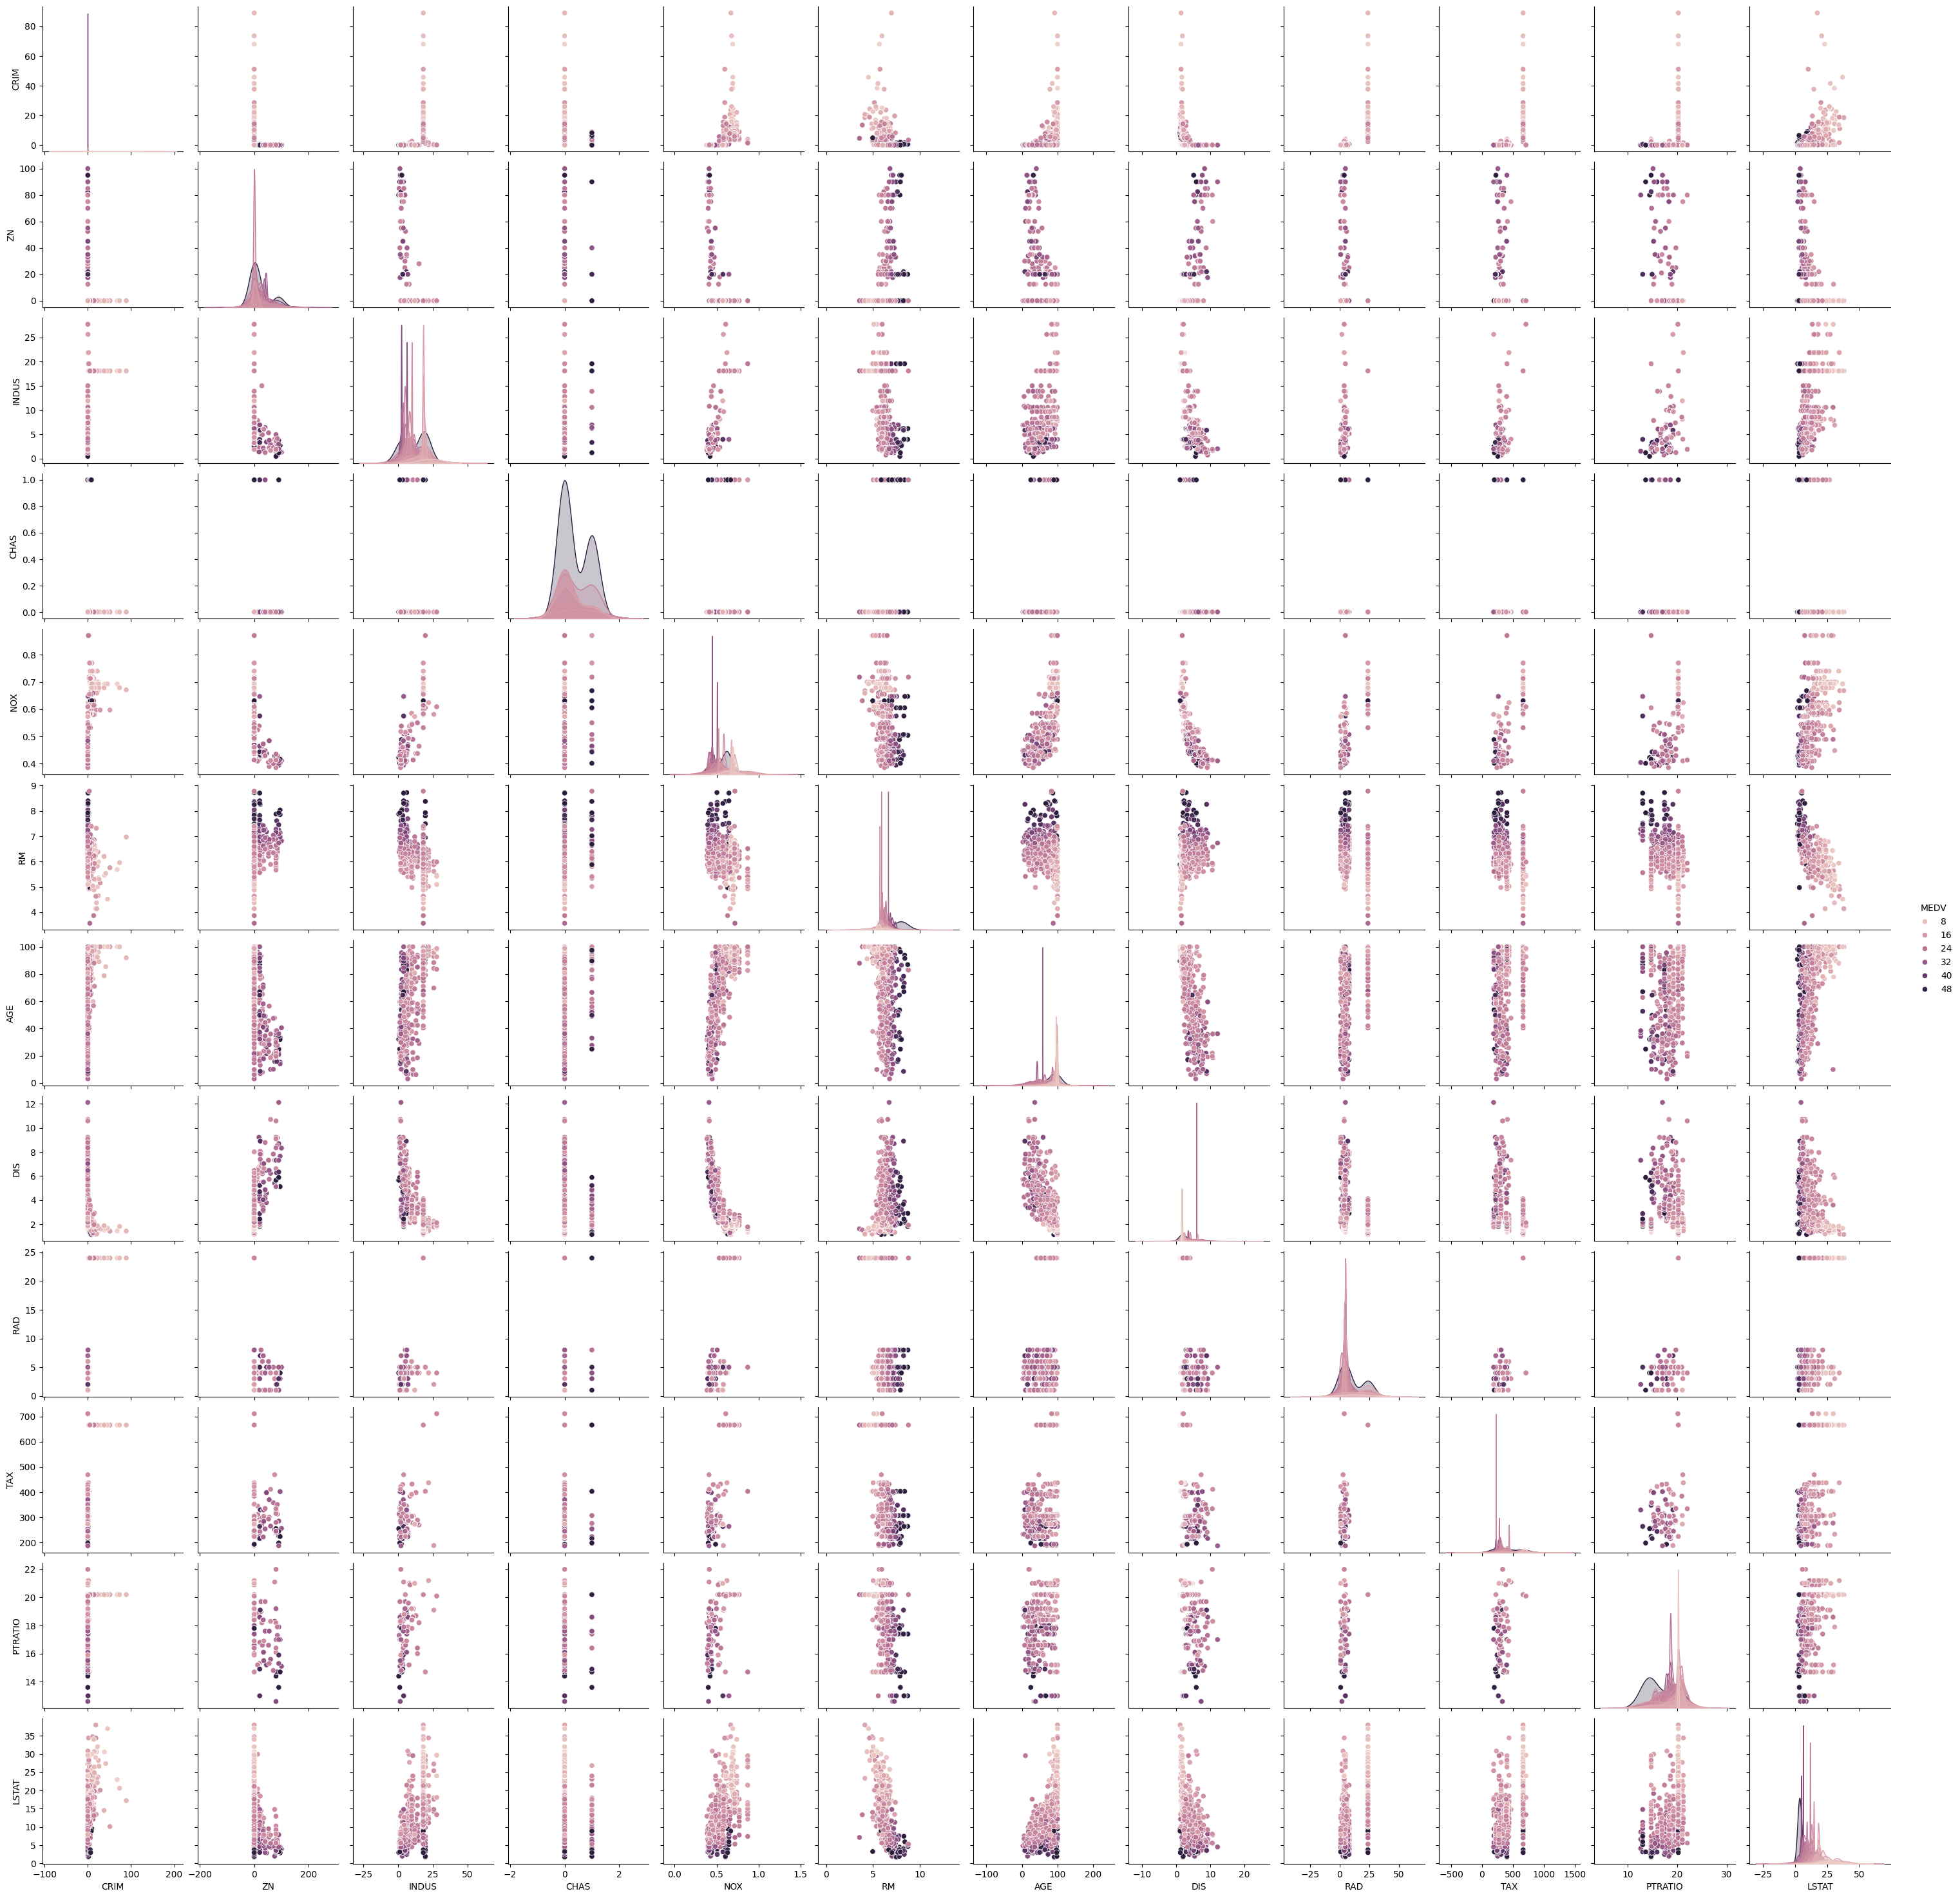

In [19]:
# Observamos graficamente el comportamiento de las variables 'X' y 'Y'
# enfoncandos o usando como pista la variable categórica 'MEDV'
sns.pairplot(df, hue="MEDV")

#### Defina como variable respuesta a la columna MEDV. Realice una partición 80-20, donde el primer 80 % de los datos son datos de entrenamiento y el restante 20 % son datos para prueba.

In [40]:
# definimos también una semilla de random_state = 1 para que la partición cada vez que se corra sea la misma.
X = df.drop(columns="MEDV")
Y = df.MEDV
(X_training, X_test, y_training, y_test) = train_test_split(X, Y, train_size=0.8, random_state=1)

In [41]:
# Verificación de la distribución de 80% entrenamiento(training) y 20% prueba(test)
len( X_training ), len( X_test ), len( y_training ), len( y_test )

(404, 102, 404, 102)

In [42]:
len(df)

506

In [43]:
training_percentage = (len(X_training) * 100) / len(df)
print(f"Porcentaje de datos de entrenamiento: {training_percentage:.2f}%")
print(f"Porcentaje de datos de prueba: {100 - training_percentage:.2f}%")

Porcentaje de datos de entrenamiento: 79.84%
Porcentaje de datos de prueba: 20.16%


#### - Genere los modelos de regresión por regularización **Ridge, LASSO y Elastic-Net** para los datos de entrenamiento. Encuentre los valores óptimos de $α$ y $λ$ junto a su respectiva gráfica de evolución de los coeficientes de regresión. Compare los modelos en términos de la selección de variables, interprete los coeficientes y escriba la ecuación ajustada de regresión para cada caso. Finalmente, realice una predicción con las observaciones de prueba y determine cual de los tres modelos es el mejor en capacidad predictiva **(RMSE)**.

In [47]:
# Definimos los modelos
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()

# Definimos los parámetros para la búsqueda de cuadrícula
parametros = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Creamos los objetos GridSearchCV
grid_ridge = GridSearchCV(ridge, parametros, scoring='neg_mean_squared_error', cv=5)
grid_lasso = GridSearchCV(lasso, parametros, scoring='neg_mean_squared_error', cv=5)
grid_elastic_net = GridSearchCV(elastic_net, parametros, scoring='neg_mean_squared_error', cv=5)

# Entrenamos los modelos
grid_ridge.fit(X_training, y_training)
grid_lasso.fit(X_training, y_training)
grid_elastic_net.fit(X_training, y_training)

# Imprimimos los mejores parámetros
print(f'El mejor valor de alpha para Ridge es: {grid_ridge.best_params_}')
print(f'El mejor valor de alpha para LASSO es: {grid_lasso.best_params_}')
print(f'El mejor valor de alpha para ElasticNet es: {grid_elastic_net.best_params_}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.604e+03, tolerance: 2.681e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+03, tolerance: 2.548e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e+03, tolerance: 2.744e

El mejor valor de alpha para Ridge es: {'alpha': 0.01}
El mejor valor de alpha para LASSO es: {'alpha': 0.0001}
El mejor valor de alpha para ElasticNet es: {'alpha': 0.0001}


In [50]:
# Obtenemos los coeficientes de los modelos
ridge_coef = grid_ridge.best_estimator_.coef_
lasso_coef = grid_lasso.best_estimator_.coef_
elastic_net_coef = grid_elastic_net.best_estimator_.coef_

# Imprimimos los coeficientes
print(f'Coeficientes de Ridge: {ridge_coef}')
print(f'\nCoeficientes de LASSO: {lasso_coef}')
print(f'\nCoeficientes de ElasticNet: {elastic_net_coef}')


Coeficientes de Ridge: [-1.19663562e-01  5.82414597e-02  1.13190270e-02  2.23872527e+00
 -2.01872902e+01  3.00244038e+00  6.18102190e-03 -1.51332791e+00
  2.87129496e-01 -1.13108790e-02 -9.70594948e-01 -5.65129660e-01]

Coeficientes de LASSO: [-1.19730490e-01  5.82331652e-02  1.18977141e-02  2.23988328e+00
 -2.03160034e+01  3.00104646e+00  6.29170192e-03 -1.51519220e+00
  2.87447024e-01 -1.12987800e-02 -9.72094529e-01 -5.64986119e-01]

Coeficientes de ElasticNet: [-1.19568761e-01  5.82523715e-02  1.05116277e-02  2.23481263e+00
 -2.00078048e+01  3.00389859e+00  6.03497695e-03 -1.51066208e+00
  2.86693558e-01 -1.13280427e-02 -9.68531104e-01 -5.65368515e-01]


In [49]:
# Obtenemos los nombres de las variables
variables = X_training.columns

# Escribimos la ecuación de regresión para cada modelo
print('Ecuación de regresión para Ridge:')
print('MEDV = ' + ' + '.join([f'{coef}*{var}' for coef, var in zip(ridge_coef, variables)]))
print('\nEcuación de regresión para LASSO:')
print('MEDV = ' + ' + '.join([f'{coef}*{var}' for coef, var in zip(lasso_coef, variables)]))
print('\nEcuación de regresión para ElasticNet:')
print('MEDV = ' + ' + '.join([f'{coef}*{var}' for coef, var in zip(elastic_net_coef, variables)]))


Ecuación de regresión para Ridge:
MEDV = -0.11966356152992905*CRIM + 0.058241459658412945*ZN + 0.011319027037916516*INDUS + 2.238725265349053*CHAS + -20.18729015852548*NOX + 3.002440376563838*RM + 0.006181021903021861*AGE + -1.5133279145085585*DIS + 0.28712949637989327*RAD + -0.011310879022922844*TAX + -0.9705949475811495*PTRATIO + -0.5651296602407088*LSTAT

Ecuación de regresión para LASSO:
MEDV = -0.1197304902303978*CRIM + 0.0582331651521205*ZN + 0.011897714051068724*INDUS + 2.2398832804339825*CHAS + -20.316003374409778*NOX + 3.001046455372296*RM + 0.00629170192407975*AGE + -1.5151922000889568*DIS + 0.28744702374605685*RAD + -0.01129877998549523*TAX + -0.9720945289715046*PTRATIO + -0.5649861187368667*LSTAT

Ecuación de regresión para ElasticNet:
MEDV = -0.11956876112918648*CRIM + 0.05825237149657264*ZN + 0.010511627691301638*INDUS + 2.234812630506272*CHAS + -20.00780484530828*NOX + 3.00389859253273*RM + 0.006034976950372748*AGE + -1.5106620771346855*DIS + 0.28669355834619914*RAD + -0

In [51]:
# Definimos los modelos
ridge = Ridge(alpha=0.01)
lasso = Lasso(alpha=0.0001)
elastic_net = ElasticNet(alpha=0.0001, l1_ratio=0.5)

# Entrenamos los modelos
ridge.fit(X_training, y_training)
lasso.fit(X_training, y_training)
elastic_net.fit(X_training, y_training)

# Predecimos con los modelos
ridge_pred = ridge.predict(X_training)
lasso_pred = lasso.predict(X_training)
elastic_net_pred = elastic_net.predict(X_training)